In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
import os
import sys
sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfunc_ls
import tools

In [3]:
def perh():
    return (cosmo.H(0.) / 100 * u.Mpc / u.km * u.s) / cu.littleh

In [4]:
def get_dx(z, sigma_z):
    return sigma_z * (1 + z) * c.c.to(u.km/u.s) / cosmo.H(z) * perh()

In [5]:
def Gaussian_draw(dx, size=None):
    if isinstance(dx, u.Quantity):
        return np.random.normal(loc=0.0, scale=dx.value, size=size) * dx.unit
    else:
        return np.random.normal(loc=0.0, scale=dx, size=size)

In [6]:
def eval_Gaussian(loc, sigma, mean=0.):
    # pre = 1 / (sigma * np.sqrt(2 * np.pi))
    pre = 1 / sigma.unit if hasattr(sigma, 'unit') else 1
    exp = -(loc-mean)**2 / (2 * sigma**2)
    return pre * np.e**exp

### construct three samples

In [7]:
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)
sigma_z = 0.01  # one of the 5 redshift error bins in SPHEREx

**spectroscopic sample:** SPHEREx-like galaxies from TNG; spans 3D box

In [8]:
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2
assert np.all(gal_pos_spec <= sim.boxsize)

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


**photometric sample:** SPHEREx-like galaxies from TNG at the target redshift; selected from spectroscopic sample with a Gaussian centered at the box center

In [9]:
# dx = the standard deviation of the distance spread along the LOS
dx = get_dx(redshift, sigma_z)
dx

<Quantity 34.14988849 Mpc / littleh>

In [10]:
# select galaxies from the spectroscopic sample
gal_pos_phot = []
for i, pos in enumerate(gal_pos_spec):
    draw = eval_Gaussian(pos[2], dx) * dx.unit
    if draw > np.random.uniform():
        gal_pos_phot.append(pos)
    else:
        continue
gal_pos_phot = np.array(gal_pos_phot) * dx.unit

In [11]:
gal_pos_phot.shape

(9992, 3)

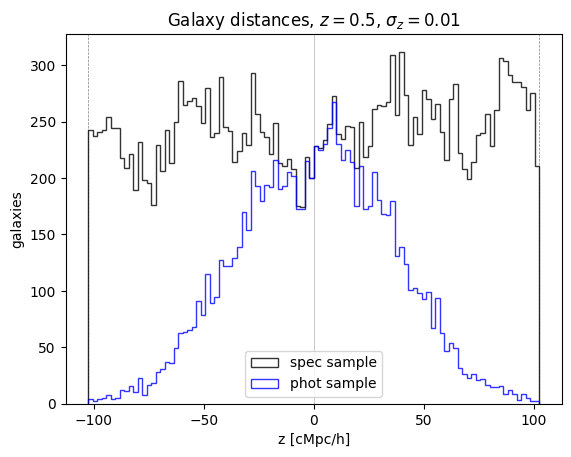

In [12]:
fig, ax = plt.subplots()
kwargs = dict(histtype='step', lw=1, alpha=0.8)
_, bins, _ = ax.hist(gal_pos_spec[:,2].value, bins=100, color='k', label='spec sample', **kwargs)
_, _, _ = ax.hist(gal_pos_phot[:,2].value, bins=bins, color='b', label='phot sample', **kwargs)
ax.axvline(-(sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline((sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline(0, ls='-', color='k', lw=0.5, alpha=0.3)
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('galaxies')
ax.set_title(f'Galaxy distances, $z={redshift}$, $\sigma_z={sigma_z}$')
ax.legend()

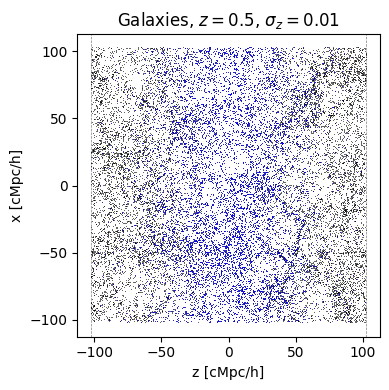

In [13]:
# compare positions
fig, ax = plt.subplots(figsize=(7,4))

kwargs = dict(ls='None', marker=',', alpha=0.6)
ax.plot(gal_pos_spec[:,2].value, gal_pos_spec[:,0].value, c='k', **kwargs)
ax.plot(gal_pos_phot[:,2].value, gal_pos_phot[:,0].value, c='b', **kwargs)
ax.axvline(-(sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.axvline((sim.boxsize.value)/2, ls='--', color='k', lw=0.5, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('z [cMpc/h]')
ax.set_ylabel('x [cMpc/h]')
ax.set_title(f'Galaxies, $z={redshift}$, $\sigma_z={sigma_z}$')
fig.tight_layout()

**underlying matter field:** DM particles from TNG; not observed in practice but used here to gain more insight

In [14]:
# load dm positions and subsample
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100, verbose=True)

subsampling 2441406 random particles...


### compute cross-correlations

In [15]:
# params
randmult = 1
rpmin = 1.
rpmax = 75.
nbins = 20
pimax = 10.
nthreads = 12

rmin = 1.
rmax = 75.

In [16]:
# divide into narrow 2D slices along the LOS
nslices = 10
losbins = np.linspace(-102.5, 102.5, nslices+1)

slices_spec = []
slices_phot = []
for i in range(nslices):
    idx_spec = (losbins[i] <= gal_pos_spec[:,2].value) & (gal_pos_spec[:,2].value < losbins[i+1])
    idx_phot = (losbins[i] <= gal_pos_phot[:,2].value) & (gal_pos_phot[:,2].value < losbins[i+1])
    slices_spec.append(gal_pos_spec[idx_spec])
    slices_phot.append(gal_pos_phot[idx_phot])

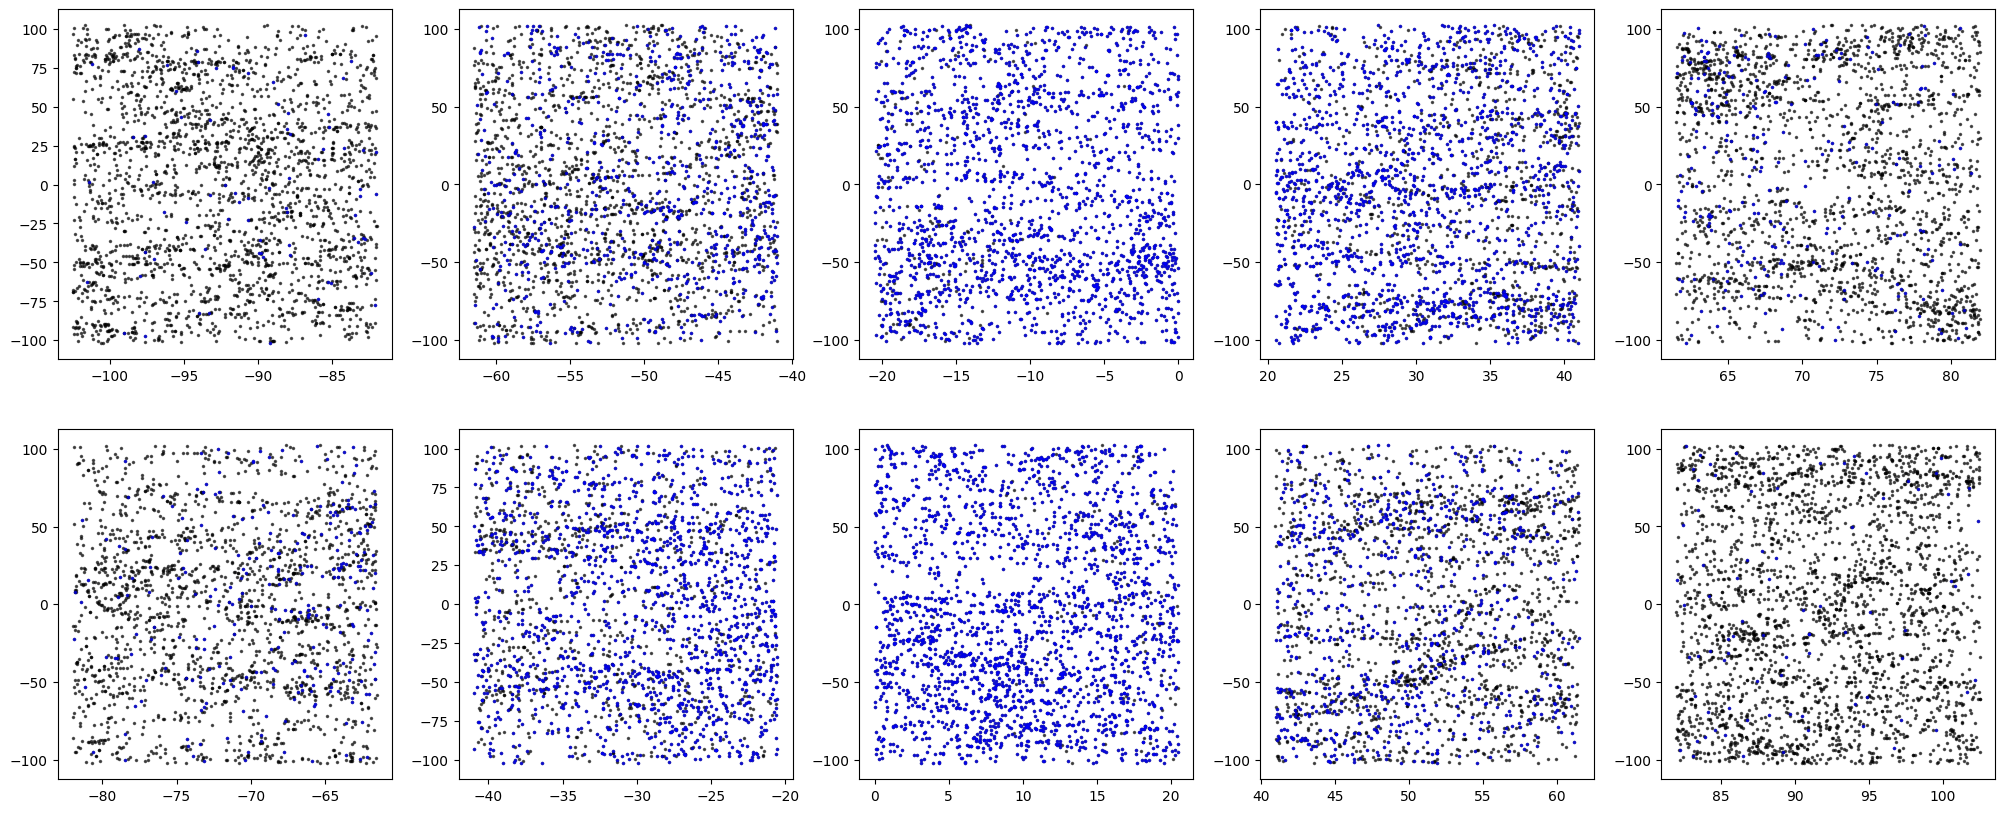

In [17]:
# check out the slices
nrows, ncols = 2, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 5))
kwargs = dict(ls='None', marker='.', ms=3, alpha=0.6)
for i in range(nslices):
    row = i % nrows
    col = (i - row) // nrows
    axs[row,col].plot(slices_spec[i][:,2].value, slices_spec[i][:,0].value, c='k', **kwargs)
    axs[row,col].plot(slices_phot[i][:,2].value, slices_phot[i][:,0].value, c='b', **kwargs)

### phot x spec

In [19]:
# shift data to be all positive (required for Corrfunc)
phot_sample = gal_pos_phot + sim.boxsize / 2
spec_sample = gal_pos_spec + sim.boxsize / 2
phot_slices = [x + sim.boxsize / 2 for x in slices_phot]
spec_slices = [x + sim.boxsize / 2 for x in slices_spec]

In [20]:
# bin edges along LOS
losbins + sim.boxsize.value / 2

array([  0. ,  20.5,  41. ,  61.5,  82. , 102.5, 123. , 143.5, 164. ,
       184.5, 205. ])

In [21]:
# slice centers (for plotting)
slice_centers = np.array([(losbins[i]+losbins[i+1])/2 for i in range(nslices)])
slice_centers

array([-92.25, -71.75, -51.25, -30.75, -10.25,  10.25,  30.75,  51.25,
        71.75,  92.25])

#### 3D autocorrs

In [22]:
spec_autocorrs = np.empty((nslices, nbins))
phot_autocorrs = np.empty((nslices, nbins))
for i in range(nslices):
    ravg, spec_autocorrs[i] = corrfunc_ls.compute_3D_ls_auto(spec_slices[i], randmult,
                                                          rmin, rmax, nbins,
                                                          logbins=True, periodic=True, boxsize=sim.boxsize.value,
                                                          zrange=(losbins[i], losbins[i+1]) + sim.boxsize.value / 2)
    ravg, phot_autocorrs[i] = corrfunc_ls.compute_3D_ls_auto(phot_slices[i], randmult,
                                                          rmin, rmax, nbins,
                                                          logbins=True, periodic=True, boxsize=sim.boxsize.value,
                                                          zrange=(losbins[i], losbins[i+1]) + sim.boxsize.value / 2)

/work/08811/aew492/ls6/small-scale_cross-corrs/corrfunc_ls.py:93: RuntimeWarning: Mean of empty slice
  return r_avg, np.nanmean(xis, axis=0)


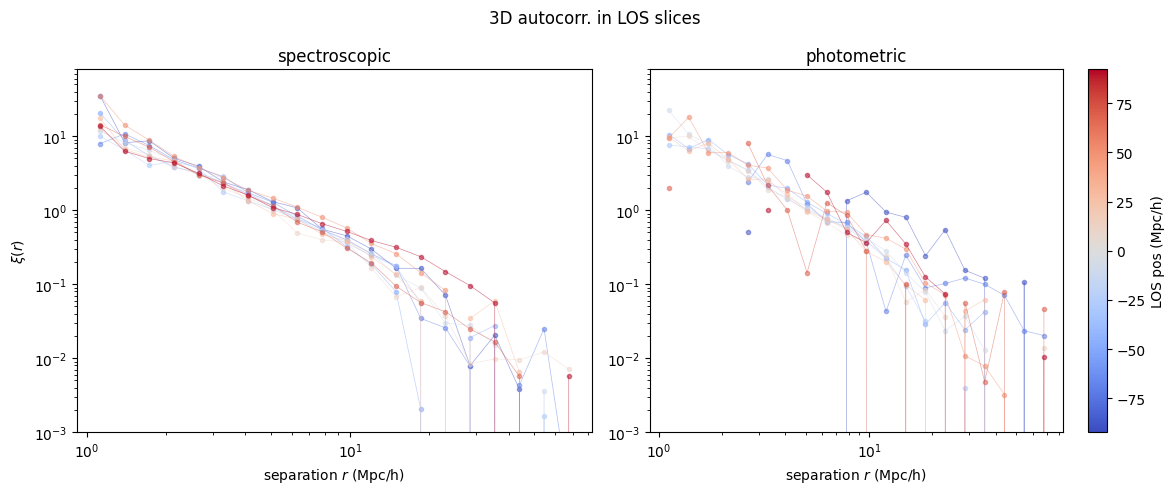

In [23]:
norm = mpl.colors.Normalize(vmin=min(slice_centers), vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)

fig, axs = plt.subplots(1, 2, figsize=(12,5))
for i, pos in enumerate(slice_centers):
    axs[0].plot(ravg, spec_autocorrs[i], marker='.', alpha=0.5, lw=0.5, c=smap.to_rgba(pos))
    axs[1].plot(ravg, phot_autocorrs[i], marker='.', alpha=0.5, lw=0.5, c=smap.to_rgba(pos))
for ax in axs:
    ax.loglog()
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.set_ylim(1e-3, 8e1)
axs[0].set_ylabel(r'$\xi(r)$')
axs[0].set_title('spectroscopic')
axs[1].set_title('photometric')
# axs[1].set_yticklabels([])
fig.colorbar(smap, ax=axs[1], label='LOS pos (Mpc/h)')
fig.suptitle('3D autocorr. in LOS slices')
fig.tight_layout()

#### 3D cross

In [24]:
%%time
xcorrs = np.empty((nslices, nbins))
for i in range(nslices):
    ravg, xcorrs[i] = corrfunc_ls.compute_3D_ls_cross(phot_slices[i], spec_slices[i], randmult,
                                                 rmin, rmax, nbins, logbins=True,
                                                  periodic=True, boxsize=sim.boxsize.value,
                                                 zrange=(losbins[i], losbins[i+1]) + sim.boxsize.value / 2)

CPU times: user 2.02 s, sys: 22.7 ms, total: 2.05 s
Wall time: 173 ms


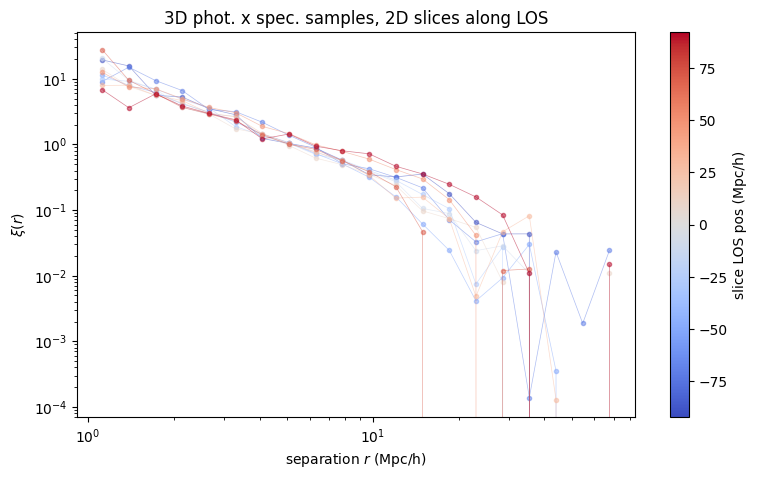

In [25]:
norm = mpl.colors.Normalize(vmin=min(slice_centers), vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)

fig, ax = plt.subplots(figsize=(9,5))
for i, pos in enumerate(slice_centers):
    ax.plot(ravg, xcorrs[i], marker='.', alpha=0.5, lw=0.5, c=smap.to_rgba(pos))
ax.loglog()
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$\xi(r)$')
ax.set_title('3D phot. x spec. samples, 2D slices along LOS')
fig.colorbar(smap, ax=ax, label='slice LOS pos (Mpc/h)')

#### 2D auto

In [26]:
spec_2d_autocorrs = np.empty((nslices, nbins))
phot_2d_autocorrs = np.empty((nslices, nbins))
for i in range(nslices):
    ravg, spec_2d_autocorrs[i] = corrfunc_ls.compute_2D_ls_auto(spec_slices[i], randmult,
                                                          rpmin, rpmax, nbins, pimax,
                                                          logbins=True, periodic=True, boxsize=sim.boxsize.value,
                                                          zrange=(losbins[i], losbins[i+1]) + sim.boxsize.value / 2)
    ravg, phot_2d_autocorrs[i] = corrfunc_ls.compute_2D_ls_auto(phot_slices[i], randmult,
                                                          rpmin, rpmax, nbins, pimax,
                                                          logbins=True, periodic=True, boxsize=sim.boxsize.value,
                                                          zrange=(losbins[i], losbins[i+1]) + sim.boxsize.value / 2)

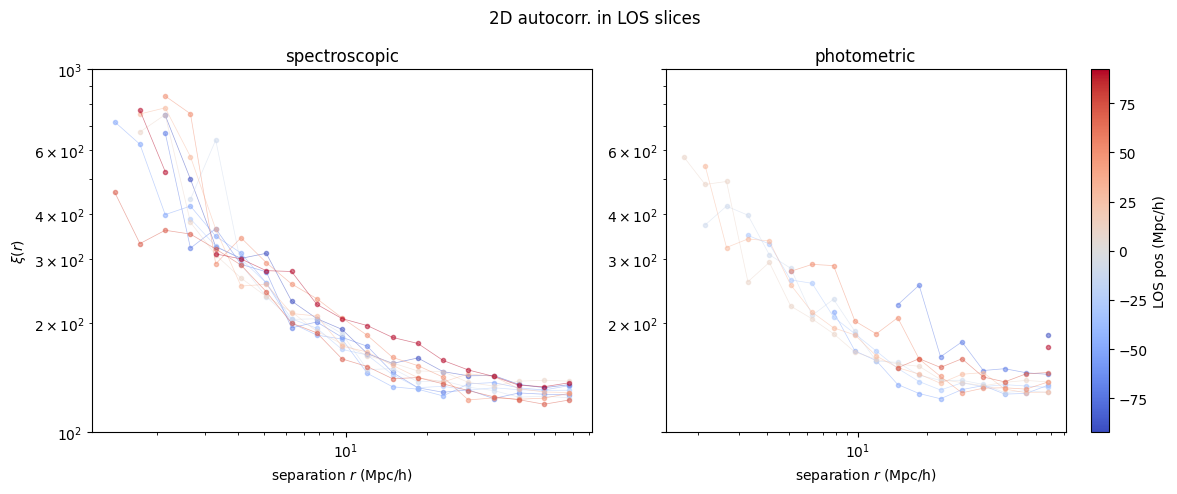

In [29]:
norm = mpl.colors.Normalize(vmin=min(slice_centers), vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)

fig, axs = plt.subplots(1, 2, figsize=(12,5))
for i, pos in enumerate(slice_centers):
    axs[0].plot(ravg, spec_2d_autocorrs[i], marker='.', alpha=0.5, lw=0.5, c=smap.to_rgba(pos))
    axs[1].plot(ravg, phot_2d_autocorrs[i], marker='.', alpha=0.5, lw=0.5, c=smap.to_rgba(pos))
for ax in axs:
    ax.loglog()
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.set_ylim(1e2, 1e3)
axs[0].set_ylabel(r'$\xi(r)$')
axs[0].set_title('spectroscopic')
axs[1].set_title('photometric')
axs[1].set_yticklabels([])
fig.colorbar(smap, ax=axs[1], label='LOS pos (Mpc/h)')
fig.suptitle('2D autocorr. in LOS slices')
fig.tight_layout()

#### 2D cross

In [30]:
%%time
xcorrs = np.empty((nslices, nbins))
for i in range(nslices):
    rpavg, xcorrs[i] = corrfunc_ls.compute_2D_ls_cross(phot_slices[i], spec_slices[i], randmult,
                                                      rpmin, rpmax, nbins, pimax,
                                                      logbins=True, periodic=True, boxsize=sim.boxsize.value,
                                                       zrange=(losbins[i], losbins[i+1]) + sim.boxsize.value / 2)

CPU times: user 2.13 s, sys: 13.5 ms, total: 2.15 s
Wall time: 181 ms


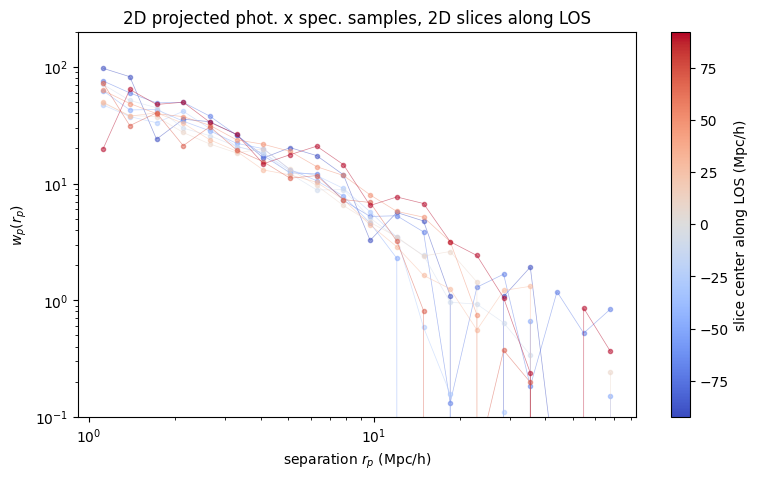

In [31]:
fig, ax = plt.subplots(figsize=(9,5))
for i, pos in enumerate(slice_centers):
    ax.plot(ravg, xcorrs[i], marker='.', alpha=0.5, lw=0.5, c=smap.to_rgba(pos))
ax.loglog()
ax.set_ylim(1e-1, 2e2)
ax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax.set_ylabel(r'$w_p(r_p)$')
ax.set_title('2D projected phot. x spec. samples, 2D slices along LOS')
fig.colorbar(smap, ax=ax, label='slice center along LOS (Mpc/h)')

### new photometric sample: collapse into one slice but retain redshift distribution

In [32]:
phot_sample.shape

(9937, 3)

Text(0.5, 1.0, 'photometric sample')

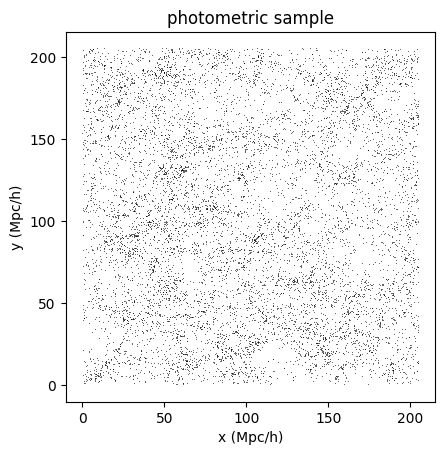

In [38]:
fig, ax = plt.subplots()
ax.plot(phot_sample[:,0], phot_sample[:,1], marker=',', c='k', ls='None', alpha=0.6)
ax.set_aspect('equal')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_title('photometric sample')

In [39]:
# shift to center at zero
phot_sample -= sim.boxsize / 2
# collapse LOS dimension into a single compressed slice around the center
phot_sample_col = np.copy(phot_sample)
phot_sample_col

<Quantity 0.97029877 Mpc / littleh>